In [1]:
import pandas as pd
import numpy as np
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
import xgboost as xgb
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
sns.set_palette('husl')

In [2]:
# Load and preprocess data
print("Loading data...")

df = pd.read_excel('amazon_wine.xlsx')

# remove rows where vintage is NV
df = df[df['Vintage'] != 'NV']

# remove ml/L from Bottle Size column
df['Bottle Size'] = df['Bottle Size'].astype(str).str.extract(r'([\d.]+)').astype(float)

# Remove price outliers using IQR
Q1 = df['Price'].quantile(0.1)
Q3 = df['Price'].quantile(0.9)
IQR = Q3 - Q1
df = df[
    (df['Price'] >= Q1 - 1.5 * IQR) &
    (df['Price'] <= Q3 + 1.5 * IQR)
]

# Transform prices to log scale
df['Price_Log'] = np.log1p(df['Price'])

df = df.dropna(subset=['Price','Description'])

print("\nShape after cleaning:", df.shape)
display(df.head())


Loading data...

Shape after cleaning: (1828, 17)


,Producer,Product,Link,Price,Stock Availability,Bottle Size,Ratings,Reviewers,Description,Vintage,Variety,Region,Color/Type,Country,Appellation,SubRegion,Price_Log
64,Chateau Lafite Rothschild,2022 Chateau Lafite Rothschild - Pauillac (Bor...,https://bassins.com/2022-chateau-lafite-rothsc...,760.0,76,750.0,97-99,JD,The 2022 Château Lafite-Rothschild is based on...,2022,Red Blend,Bordeaux,Red,France,Pauillac,NaN,6.634633
65,Jean-Marie Fourrier,2017 Jean-Marie Fourrier - Chambertin Vieille ...,https://bassins.com/2017-jean-marie-fourrier-c...,749.0,4,750.0,(94-96),VM,"The 2017 Chambertin Grand Cru has a charming, ...",2017,NaN,Burgundy,Red,France,Chambertin,NaN,6.620073
66,Georges Noellat,2019 Georges Noellat - Grands Echezeaux,https://bassins.com/2019-georges-noellat-grand...,749.0,12,750.0,(96-98),VM,"For the first time, Maxime Chuerlin decided to...",2019,Pinot Noir/Pinot Nero,Burgundy,Red,France,Grands Echezeaux,NaN,6.620073
67,Louis Latour,2020 Louis Latour - Montrachet,https://bassins.com/2020-louis-latour-montrach...,749.0,9,750.0,98,JS,If you are looking for the ultimate in white B...,2020,NaN,Burgundy,White,France,Montrachet,NaN,6.620073
69,Chateau Ausone,2022 Chateau Ausone - St. Emilion (Bordeaux Fu...,https://bassins.com/2022-chateau-ausone-st-emi...,740.0,22,750.0,96-98,JD,The Grand Vin from this hallowed terroir is an...,2022,Red Blend,Bordeaux,Red,France,St. Emilion,NaN,6.608001


In [3]:
bloc = df['Description']
bloc

64      The 2022 Château Lafite-Rothschild is based on...
65      The 2017 Chambertin Grand Cru has a charming, ...
66      For the first time, Maxime Chuerlin decided to...
67      If you are looking for the ultimate in white B...
69      The Grand Vin from this hallowed terroir is an...
                              ...                        
3261    This shows notes of cherries and red plums wit...
3280    The 2019 Côtes Du Rhône will be a no-brainer p...
3290    Majority Chenin Blanc, plus Chardonnay, Viogni...
3309    Sho Chiku Bai Junmai Daiginjo: This variety is...
3313    This fresh, subtle Honjozo has a lovely nose o...
Name: Description, Length: 1828, dtype: object


Sentiment Score Statistics:
count    2360.000000
mean        0.152603
std         0.172257
min        -0.388889
25%         0.000000
50%         0.133333
75%         0.268333
max         1.000000
Name: Sentiment, dtype: float64


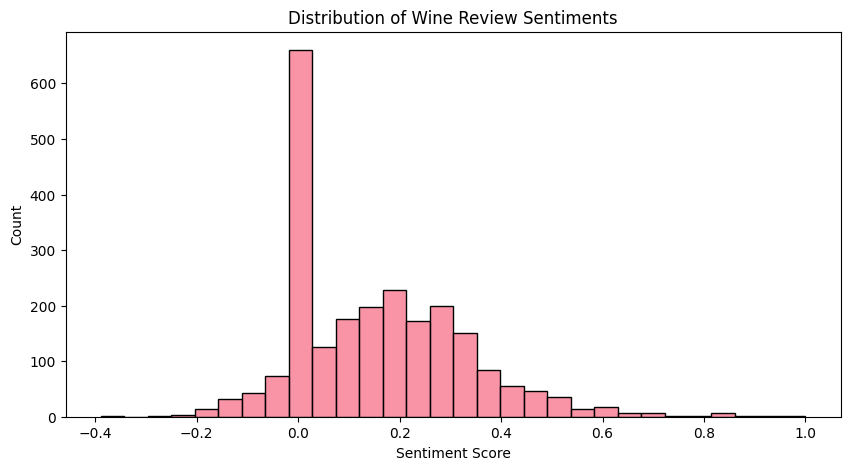

In [4]:
from textblob import TextBlob
# Create a new column for sentiment scores
df['Sentiment'] = 0.0  # Initialize with zeros

# Calculate sentiment for each description
for i in range(len(df)):
    try:
        text = df['Description'].iloc[i]
        blob = TextBlob(text)
        df.loc[i, 'Sentiment'] = blob.sentiment.polarity
    except Exception as e:
        print(f"Error processing row {i}: {e}")
        continue

# Optional: Display summary statistics of the sentiment scores
print("\nSentiment Score Statistics:")
print(df['Sentiment'].describe())

# Optional: Create a histogram of sentiment distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Sentiment'], bins=30)
plt.title('Distribution of Wine Review Sentiments')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

In [5]:
display(df.shape)
df.head()

(2360, 18)

,Producer,Product,Link,Price,Stock Availability,Bottle Size,Ratings,Reviewers,Description,Vintage,Variety,Region,Color/Type,Country,Appellation,SubRegion,Price_Log,Sentiment
64,Chateau Lafite Rothschild,2022 Chateau Lafite Rothschild - Pauillac (Bor...,https://bassins.com/2022-chateau-lafite-rothsc...,760.0,76.0,750.0,97-99,JD,The 2022 Château Lafite-Rothschild is based on...,2022,Red Blend,Bordeaux,Red,France,Pauillac,NaN,6.634633,0.301190
65,Jean-Marie Fourrier,2017 Jean-Marie Fourrier - Chambertin Vieille ...,https://bassins.com/2017-jean-marie-fourrier-c...,749.0,4.0,750.0,(94-96),VM,"The 2017 Chambertin Grand Cru has a charming, ...",2017,NaN,Burgundy,Red,France,Chambertin,NaN,6.620073,0.245238
66,Georges Noellat,2019 Georges Noellat - Grands Echezeaux,https://bassins.com/2019-georges-noellat-grand...,749.0,12.0,750.0,(96-98),VM,"For the first time, Maxime Chuerlin decided to...",2019,Pinot Noir/Pinot Nero,Burgundy,Red,France,Grands Echezeaux,NaN,6.620073,-0.012500
67,Louis Latour,2020 Louis Latour - Montrachet,https://bassins.com/2020-louis-latour-montrach...,749.0,9.0,750.0,98,JS,If you are looking for the ultimate in white B...,2020,NaN,Burgundy,White,France,Montrachet,NaN,6.620073,0.039394
69,Chateau Ausone,2022 Chateau Ausone - St. Emilion (Bordeaux Fu...,https://bassins.com/2022-chateau-ausone-st-emi...,740.0,22.0,750.0,96-98,JD,The Grand Vin from this hallowed terroir is an...,2022,Red Blend,Bordeaux,Red,France,St. Emilion,NaN,6.608001,0.160833


In [6]:
# remove the columns that are not needed
columns_to_drop = ['Ratings', 'Reviewers', 'SubRegion', 'Description', 'Stock Availability','Price_Log']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

# # Drop all rows with NaN values from the df DataFrame
# df = df.dropna()
# # remove rows where vintage is NV
# df = df[df['Vintage'] != 'NV']
# rename ml/L from Bottle Size column to float
# df['Bottle Size'] = df['Bottle Size'].astype(str).str.extract(r'([\d.]+)').astype(float)

display(df.shape)
df.head()


(2360, 11)

,Producer,Product,Link,Price,Bottle Size,Vintage,Variety,Region,Color/Type,Country,Appellation
64,Chateau Lafite Rothschild,2022 Chateau Lafite Rothschild - Pauillac (Bor...,https://bassins.com/2022-chateau-lafite-rothsc...,760.0,750.0,2022,Red Blend,Bordeaux,Red,France,Pauillac
65,Jean-Marie Fourrier,2017 Jean-Marie Fourrier - Chambertin Vieille ...,https://bassins.com/2017-jean-marie-fourrier-c...,749.0,750.0,2017,NaN,Burgundy,Red,France,Chambertin
66,Georges Noellat,2019 Georges Noellat - Grands Echezeaux,https://bassins.com/2019-georges-noellat-grand...,749.0,750.0,2019,Pinot Noir/Pinot Nero,Burgundy,Red,France,Grands Echezeaux
67,Louis Latour,2020 Louis Latour - Montrachet,https://bassins.com/2020-louis-latour-montrach...,749.0,750.0,2020,NaN,Burgundy,White,France,Montrachet
69,Chateau Ausone,2022 Chateau Ausone - St. Emilion (Bordeaux Fu...,https://bassins.com/2022-chateau-ausone-st-emi...,740.0,750.0,2022,Red Blend,Bordeaux,Red,France,St. Emilion


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import uniform, randint
import torch


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
# One-hot encode categorical features
categorical_columns = df.select_dtypes(include=['object']).columns
wine_price_2_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
print("Initial shape:", wine_price_2_encoded.shape)

# Remove extreme outliers based on IQR
Q1 = wine_price_2_encoded['Price'].quantile(0.1)
Q3 = wine_price_2_encoded['Price'].quantile(0.9)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
wine_price_2_encoded = wine_price_2_encoded[
    (wine_price_2_encoded['Price'] >= lower_bound) &
    (wine_price_2_encoded['Price'] <= upper_bound)
]
print("Shape after outlier removal:", wine_price_2_encoded.shape)

# Prepare features (X) and target (y)
X = wine_price_2_encoded.drop(columns=['Price'])
y = wine_price_2_encoded['Price']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define parameter distributions for random search
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.3),
    'min_child_weight': randint(1, 7),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'tree_method': ['hist'],  # Use 'hist' for both CPU and GPU
    'device': [device]  # Modern way to specify device
}

# Initialize base XGBoost model with GPU support
base_model = xgb.XGBRegressor(
    random_state=42,
    tree_method='hist',
    device=device
)

# Perform RandomizedSearchCV with fewer iterations
# random_search = RandomizedSearchCV(
#     estimator=base_model,
#     param_distributions=param_distributions,
#     n_iter=30,  # Number of parameter settings sampled
#     cv=3,
#     scoring='r2',
#     n_jobs=-1,
#     verbose=1,
#     random_state=42
# )
best_params = {
    'colsample_bytree': 0.9637281608315128,
    'gamma': 0.12938999080000846,
    'learning_rate': 0.2087566853061946,
    'max_depth': 4,
    'min_child_weight': 6,
    'n_estimators': 489,
    'subsample': 0.6831766651472755,
    'tree_method': 'hist',
    'device': device
}

# Fit RandomizedSearchCV
# random_search.fit(X_scaled, y)

# Print best parameters and score
# print("\nBest parameters found:")
# # print(random_search.best_params_)
# print(f"Best cross-validation R² score: {random_search.best_score_:.3f}")

# Use best parameters for final model evaluation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = []
mae_scores = []
mse_scores = []
feature_importances = []

# Perform cross-validation with best parameters
for fold, (train_idx, val_idx) in enumerate(cv.split(X_scaled), 1):
    # Split data
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train model with best parameters and GPU support
    xg_reg = xgb.XGBRegressor(**best_params, random_state=42)
    xg_reg.fit(X_train, y_train)
    
    # Make predictions
    y_pred = xg_reg.predict(X_val)
    
    # Calculate metrics
    r2_scores.append(r2_score(y_val, y_pred))
    mae_scores.append(mean_absolute_error(y_val, y_pred))
    mse_scores.append(mean_squared_error(y_val, y_pred))
    
    # Store feature importance
    fold_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': xg_reg.feature_importances_,
        'fold': fold
    })
    feature_importances.append(fold_importance)

# Print final cross-validation results
print("\nFinal Cross-validation Results with Best Parameters:")
print(f"Mean R² score: {np.mean(r2_scores):.3f} (±{np.std(r2_scores):.3f})")
print(f"Mean MAE: {np.mean(mae_scores):.3f} (±{np.std(mae_scores):.3f})")
print(f"Mean MSE: {np.mean(mse_scores):.3f} (±{np.std(mse_scores):.3f})")

# Feature importance analysis
feature_importance_df = pd.concat(feature_importances)
feature_importance_summary = feature_importance_df.groupby('feature').agg({
    'importance': ['mean', 'std']
}).reset_index()
feature_importance_summary.columns = ['feature', 'importance_mean', 'importance_std']
feature_importance_summary = feature_importance_summary.sort_values('importance_mean', ascending=False)

print("\nTop 10 Most Important Features (across all folds):")
print("Format: Feature: Mean Importance ± Standard Deviation")
for _, row in feature_importance_summary.head(10).iterrows():
    print(f"{row['feature']}: {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")

Using device: cuda
Initial shape: (2360, 4864)
Shape after outlier removal: (1828, 4864)


c:\Users\Sidewinders\Desktop\CODE\Wine---price-ratings-prediction\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [13:24:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



Final Cross-validation Results with Best Parameters:
Mean R² score: 0.370 (±0.062)
Mean MAE: 73.744 (±5.199)
Mean MSE: 13710.360 (±2319.931)

Top 10 Most Important Features (across all folds):
Format: Feature: Mean Importance ± Standard Deviation
Producer_Chateau Mouton Rothschild: 0.0480 ± 0.0458
Appellation_Chambertin: 0.0341 ± 0.0075
Appellation_Champagne: 0.0272 ± 0.0249
Country_France: 0.0252 ± 0.0036
Vintage_1999: 0.0246 ± 0.0114
Region_Champagne: 0.0232 ± 0.0228
Producer_Chateau Pavie: 0.0232 ± 0.0021
Producer_Aubert: 0.0207 ± 0.0096
Bottle Size: 0.0200 ± 0.0027
Producer_Chateau Haut Brion: 0.0197 ± 0.0271
